# LDD run and viz

In [10]:
import torch
from torch import nn
from torch import optim

import torchvision
import torchvision.transforms as T


import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image


import pymde
import tensorflow as tf
import pandas as pd


import networkx as nx
import community


import igraph as ig
import leidenalg as la

#import holoviews as hv 
#hv.extension('bokeh')

In [11]:
from data.util import get_dataset, IdxDataset
from module.loss import GeneralizedCELoss
from module.util import get_model
from util import EMA
from learner import *

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
model_l = get_model('mlp_DISENTANGLE', 10).to(device)
model_b = get_model('mlp_DISENTANGLE', 10).to(device)
decoder = get_model('AE', 3*28*28).to(device)

In [14]:
model_l.load_state_dict(torch.load(os.path.join("log/cmnist/ours_dec_DL64/result", 'best_model_l.th'), map_location=torch.device(device))['state_dict'])
model_b.load_state_dict(torch.load(os.path.join("log/cmnist/ours_dec_DL64/result", 'best_model_b.th'), map_location=torch.device(device))['state_dict'])
decoder.load_state_dict(torch.load(os.path.join("log/cmnist/ours_dec_DL64/result", 'best_model_d.th'), map_location=torch.device(device))['state_dict'])

<All keys matched successfully>

In [15]:
train_dataset = get_dataset(
            "cmnist",
            data_dir="data/",
            dataset_split="train",
            transform_split="train",
            percent="5pct"
        )



In [16]:
class CustomDataset(Dataset):
    def __init__(self):
        self.imgs_path = "data/conf/"       # path to images
        file_list = glob.glob(self.imgs_path + "*")
        print(len(file_list))
        self.data = []
        for class_path in file_list:
            bias_name = class_path.split("_")[-1].split(".")[0]
            class_name = class_path.split("_")[-2]
            #print(glob.glob(class_path + "*.png"))
            #for img_path in glob.glob(class_path + "*.png"):
            self.data.append([class_path, class_name, bias_name])
        #print(self.data)
        self.img_dim = (28,28)    
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name, bias_name = self.data[idx]
        img = Image.open(img_path).convert('RGB')
        transform = T.Compose([T.ToTensor()])
        img_tensor = transform(img)
        #img = cv2.resize(img, self.img_dim)
        class_id = int(class_name)
        bias_id = int(bias_name)
        #img_tensor = torch.from_numpy(img)
        #img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id, bias_id

In [17]:
dataset = CustomDataset()
data_loader = DataLoader(dataset, batch_size=128, shuffle=True)
i_s = 3*28*28

2449


Writing embeddings to file for DR 

In [18]:
wf = True

f = open("emb.txt", "w")
ctr = 0
for batch_features, targ, bias in data_loader:
    #print(batch_features.shape)
    label = targ
    batch_features = batch_features.view(-1, i_s).to(device)
    z_l = model_l.extract(batch_features)
    z_b = model_b.extract(batch_features)
    indices = np.random.permutation(z_b.size(0))
    z_b_swap = z_b[indices]  # z tilde
    bias_swap = bias[indices]  # y tilde
    #z = torch.cat((z_l, z_b), dim=1).to(device)
    z = torch.cat((z_l, z_b_swap), dim=1).to(device)
    rec = decoder(z)
    rec = rec.view(-1, 3, 28, 28)
    z_l = z_l.cpu().detach()
    z_b = z_b.cpu().detach()
    
    if wf:
        for e in range(len(z_l)):
            ctr +=1 
            f.write(str(targ[e].item())+";" +str(bias[e].item())+";")
            f.write(",".join([str(x) for x in z_l[e].numpy()]))
            f.write(";")
            f.write(",".join([str(x) for x in z_b[e].numpy()]))
            f.write("\n")

In [30]:
b_d = {}

for batch_features, targ, bias in data_loader:
    for i in range(len(bias)):
        b = bias[i].item()#numpy()
        t = targ[i].item() #numpy()
        if b in b_d:
            if t in b_d[b]:
                b_d[b][t] += batch_features[i]
            else:
                b_d[b][t]= batch_features[i]
        else:
            b_d[b] = {}
            b_d[b][t]= batch_features[i]
            
            
                
        

In [204]:
dir_path = "data/cmnist/5pct/conflict/"

In [206]:
for dirpath, dirname, images in os.walk(dir_path):
    print(f"There are {len(dirname)} directories with {len(images)} images in {dirpath}")
    

There are 10 directories with 0 images in data/cmnist/5pct/conflict/
There are 0 directories with 225 images in data/cmnist/5pct/conflict/8
There are 0 directories with 269 images in data/cmnist/5pct/conflict/7
There are 0 directories with 228 images in data/cmnist/5pct/conflict/5
There are 0 directories with 248 images in data/cmnist/5pct/conflict/0
There are 0 directories with 253 images in data/cmnist/5pct/conflict/6
There are 0 directories with 258 images in data/cmnist/5pct/conflict/9
There are 0 directories with 235 images in data/cmnist/5pct/conflict/3
There are 0 directories with 265 images in data/cmnist/5pct/conflict/1
There are 0 directories with 231 images in data/cmnist/5pct/conflict/4
There are 0 directories with 237 images in data/cmnist/5pct/conflict/2


Found 2449 files belonging to 10 classes.


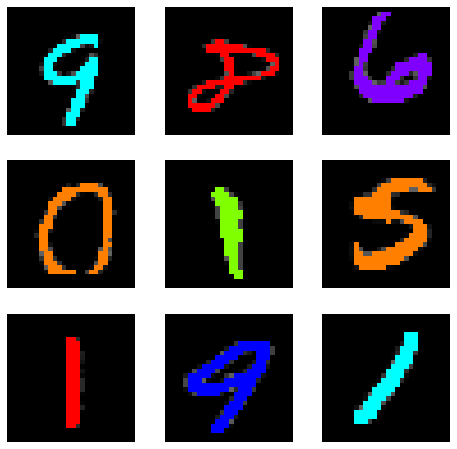

In [210]:
IMAGE_SIZE = (28, 28)

train_dir = tf.keras.preprocessing.image_dataset_from_directory(dir_path,image_size=IMAGE_SIZE)#,label_mode='binary')

plt.figure(figsize=(8, 8))
for images, labels in train_dir.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        im = images[i].numpy().astype("uint8")
        plt.imshow(im)
        plt.axis("off")

In [222]:
CLASS_LABELS = range(0,10)



def process_path(nb_class):
    
    def f(file_path):
      
        label = tf.strings.split(file_path, "_")[-2]
        bias = tf.strings.split(file_path, "_")[-1]
        bias = tf.strings.split(bias, ".")[0]
        image = tf.io.read_file(file_path)    
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
         
        return image, label, bias, file_path
    
    return f

def reader_image(path_file, batch_size, nb_class):
    list_ds = tf.data.Dataset.list_files(path_file)
    labeled_ds = list_ds.map(process_path(nb_class))
    return labeled_ds.batch(batch_size).prefetch(1), list_ds.batch(batch_size).prefetch(1)

train_ds, train_l = reader_image(dir_path+'*/*.png', 16, 2)







Outoupt : 
 image shape: (28, 28) and maximum/minimum values: (1.0, 0.0)


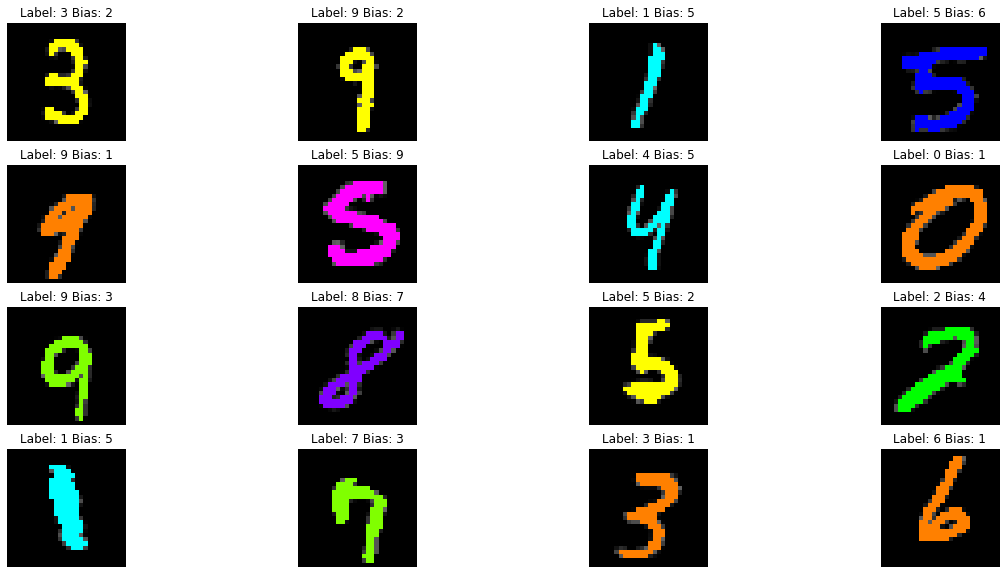

In [234]:
for image, label, bias, fn in train_ds.take(1):
    df = pd.DataFrame(image[0, :, :, 0].numpy())
    
print(f'Outoupt : \n image shape: {df.shape} and maximum/minimum values: {round(df.max().max()), round(df.min().min())}')

plt.figure(figsize=(20, 10))

for images, labels, bias, fp in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        im = images[i] 
        plt.imshow(im, )
        plt.title('Label: '+ str(int(labels[i].numpy())) + ' Bias: '+ str(int(bias[i].numpy())))
        plt.axis("off")

In [258]:
def get_numpy(ds):
    X, y, b, fps = [], [], [], []
    for images, labels, bias, fp in ds: 
        im = images
        X.append(im)
        y.append(labels.numpy())
        b.append(bias.numpy())        
        fps.append(fp)
        
    X = np.concatenate(X, axis=0)
    X = X.reshape(X.shape[0], -1)
    y = np.concatenate(y, axis=0)
    b = np.concatenate(b, axis=0)
    fps = np.concatenate(fps, axis=0)
    
    return X, y, b, fps

In [259]:
X, y, b, fps = get_numpy(train_ds)

In [260]:
def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

In [261]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


colors = [(234,50,35), (239,134,51), (255,253,84),(161,250,78), (117,249,76), (115,251,253), (0,33,245),(115,41,245),(234,53,127),(234,62,247)]

c_s = [rgb_to_dec(e) for e in colors]

cmap = ListedColormap(c_s)

Plot embedding of raw images, color by class

<AxesSubplot:>

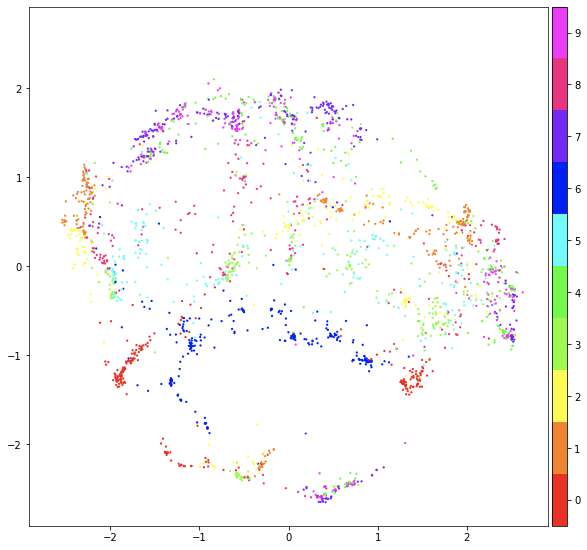

In [265]:
mde = pymde.preserve_neighbors(np.array(X), embedding_dim=2)
pymde.plot(mde.embed(), color_by=[int(e) for e in y], color_map=cmap, marker_size=5)

Plot embedding of raw images, color by bias

<AxesSubplot:>

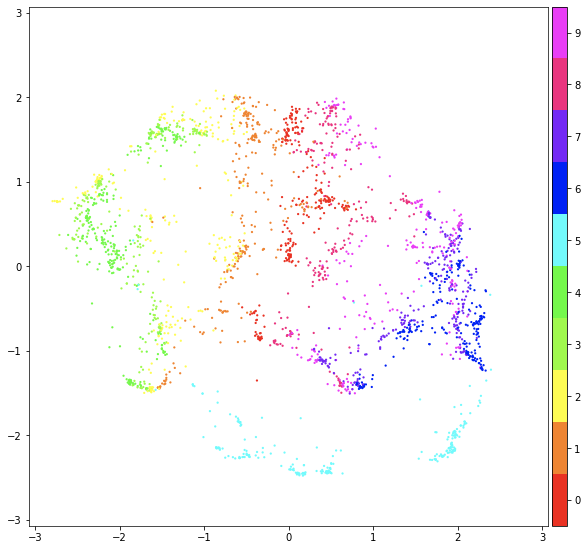

In [264]:
mde = pymde.preserve_neighbors(np.array(X), embedding_dim=2)
pymde.plot(mde.embed(), color_by=[int(x) for x in b], color_map=cmap, marker_size=5)

In [266]:
f = open("emb.txt")
X_l =[]
X_b =[]
y= []
b = []
for l in f: 
    l = l.split(";")
    y.append(l[0])
    b.append(l[1])
    X_l.append([float(x) for x in l[2].split(",")])    
    X_b.append([float(x) for x in l[3].split(",")])    



Plot bias embedding, colored by bias

<AxesSubplot:>

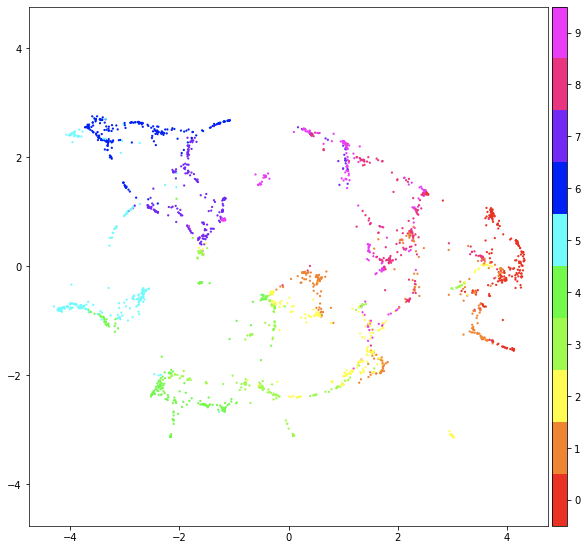

In [267]:
mde = pymde.preserve_neighbors(np.array(X_b), embedding_dim=2)
pymde.plot(mde.embed(), color_by=b,color_map=cmap, marker_size=5)

Plot bias embedding, colored by class

<AxesSubplot:>

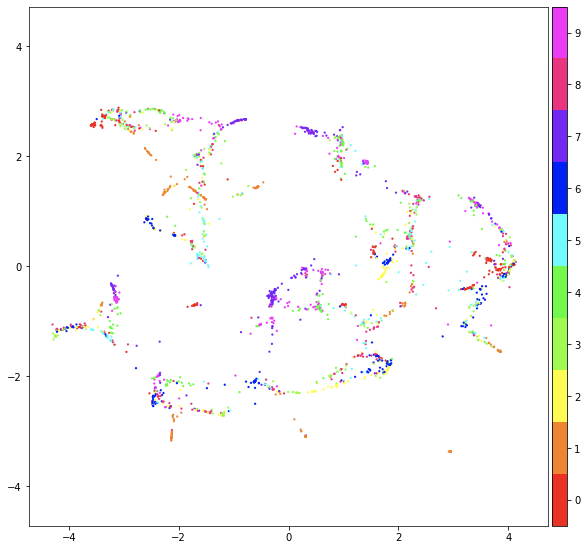

In [268]:
mde = pymde.preserve_neighbors(np.array(X_b), embedding_dim=2)
pymde.plot(mde.embed(), color_by=y,color_map=cmap, marker_size=5)

Plot class embedding, colored by class 

<AxesSubplot:>

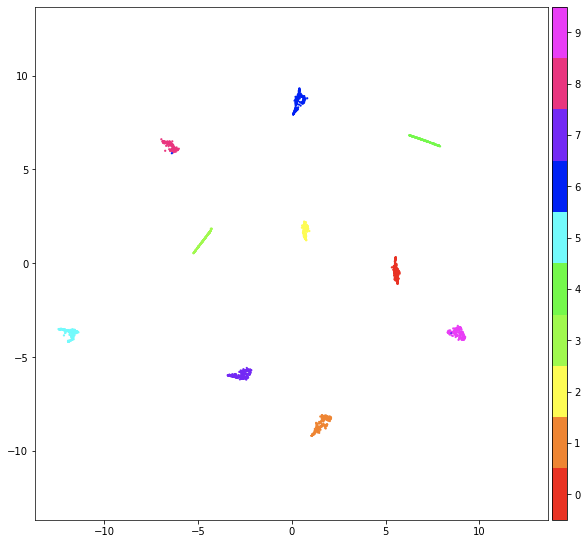

In [269]:
mde = pymde.preserve_neighbors(np.array(X_l), embedding_dim=2)
pymde.plot(mde.embed(), color_by=y,color_map=cmap, marker_size=5)

Plot class embedding, colored by class 

<AxesSubplot:>

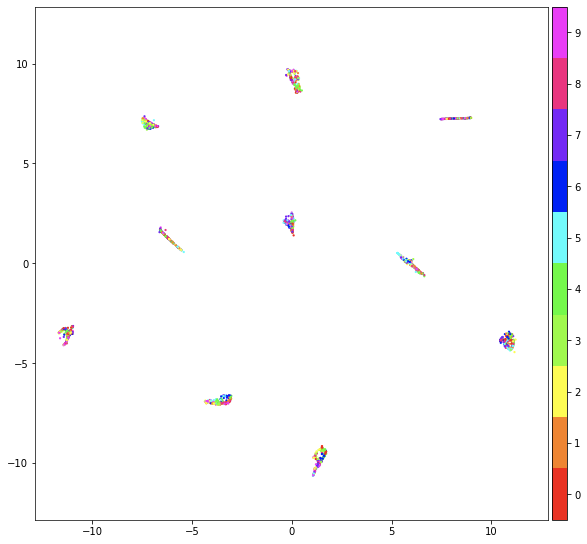

In [270]:
mde = pymde.preserve_neighbors(np.array(X_l), embedding_dim=2)
pymde.plot(mde.embed(), color_by=b,color_map=cmap, marker_size=5)

Displaying bias swap images 

In [316]:



for j in range(10):
    i = rec[j]
    ##i = i * 255
    print(label[j].item()," ", bias_swap[j].item())
    transform = T.ToPILImage()
    img = transform(i)
    img.show()
    #img.save("/Users/nversbra/Desktop/imgs/"+str(ctr)+"_"+str(label[j].item())+"_"+str(bias_swap[j].item())+".png")


5   5


5   9


4   2


7   5


0   2


0   0


3   0


9   6


1   6


3   1


Clustering of bias embeddings:

In [377]:
mde = pymde.preserve_neighbors(np.array(X_b), embedding_dim=2)#.embed()

In [337]:
emb = mde.embed()

In [371]:
from sklearn.cluster import AffinityPropagation

model = AffinityPropagation()

In [375]:
c = model.fit_predict(emb)

/home/nversbra/.conda/envs/py38/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


In [373]:
c = [e +1 for e in c]

<AxesSubplot:>

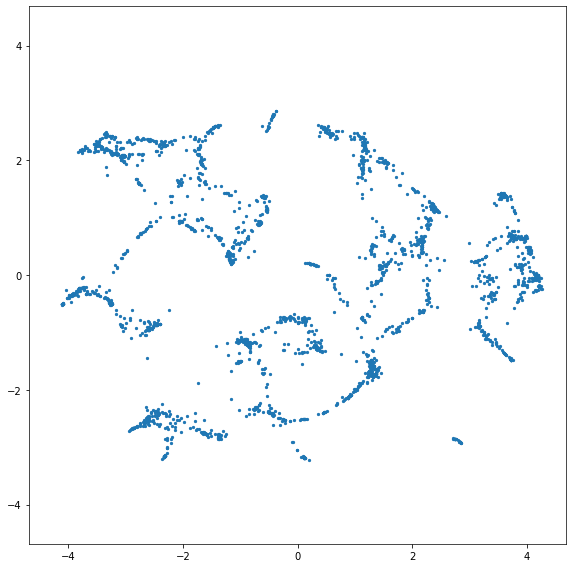

In [378]:
pymde.plot(emb,  marker_size=5)

Ignore after here 

In [283]:
edges = mde.edges
weights = mde.distortion_function.weights

In [286]:
D = nx.Graph()
D.add_nodes_from([i for i in range(mde.n_items)])
for i in range(len(edges)):
    if weights[i] > 0:
        D.add_edge(edges[i][0], edges[i][1], weight=float(weights[i]))

In [294]:
graph = pymde.Graph(nx.adjacency_matrix(D))
#emb = graph.draw()

In [ ]:
plot_network(D)

In [325]:
h = ig.Graph.from_networkx(D)

In [326]:
#partition = community.best_partition(D)
partition = la.find_partition(h, la.ModularityVertexPartition, weights='weight')#, n_iterations=10)

In [336]:
partition[0]


[2449, 2450]

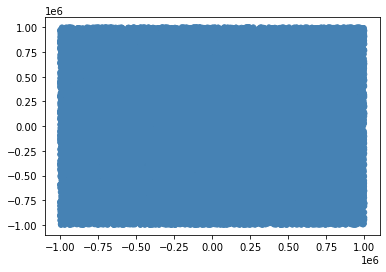

In [334]:
partition
layout = h.layout_lgl()

fig, ax = plt.subplots()


ig.plot(h, layout=layout, target = ax)

Using LDD data loader:

In [175]:
for batch_features, attr, _ in train_loader:
    print(batch_features.shape)
    label = attr[:, 0]
    bias =  attr[:, 1]
    batch_features = batch_features.view(-1, i_s).to(device)
    z_l = model_l.extract(batch_features)
    z_b = model_b.extract(batch_features)
    indices = np.random.permutation(z_b.size(0))
    z_b_swap = z_b[indices]  # z tilde
    bias_swap = bias[indices]  # y tilde
    #z = torch.cat((z_l, z_b), dim=1).to(device)
    z = torch.cat((z_l, z_b_swap), dim=1).to(device)
    rec = decoder(z)
    rec = rec.view(-1, 3, 28, 28)
    

torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
torch.Size([2, 3, 28, 28])
t